In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
from sklearn import metrics

In [3]:
PATH = "data/state-farm-distracted-driver-detection/"

In [4]:
!ls {PATH}

driver_imgs_list.csv  sample_submission.csv  test  train
models		      subm		     tmp   valid


In [5]:
label_csv = f'{PATH}driver_imgs_list.csv'
n = len(list(open(label_csv)))-1
validation_idxs = get_cv_idxs(n)

In [6]:
label_df = pd.read_csv(label_csv)
label_df.head()

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


In [7]:
label_df.pivot_table(index='classname', aggfunc=len).sort_values('img', ascending=False)

,img,subject
classname,,
c0,2489,2489
c3,2346,2346
c4,2326,2326
c6,2325,2325
c2,2317,2317
c5,2312,2312
c1,2267,2267
c9,2129,2129
c7,2002,2002


In [8]:
image_sz=480
net_arch=resnet34
batch_sz=32

In [9]:
img_transforms = tfms_from_model(net_arch, image_sz, max_zoom=1.1)

In [10]:
def get_data(sz):
    img_transforms = tfms_from_model(net_arch, image_sz, max_zoom=1.1)
    return ImageClassifierData.from_paths(path=PATH, 
                                        bs=batch_sz, 
                                        tfms=img_transforms,
                                        trn_name='train',
                                        test_name='test')

In [11]:
data = get_data(256)
data.classes

['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']

In [12]:
fn = PATH + data.trn_ds.fnames[0];fn

'data/state-farm-distracted-driver-detection/train/c0/img_75961.jpg'

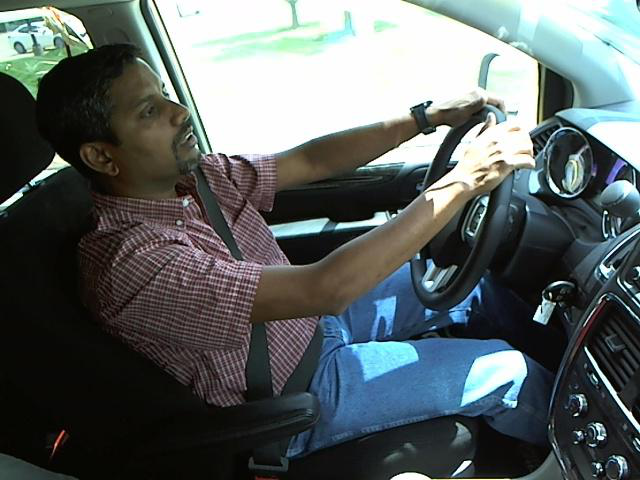

In [13]:
img = PIL.Image.open(fn); img

In [14]:
img.size

(640, 480)

(array([    0.,     0.,     0.,     0.,     0., 22424.,     0.,     0.,     0.,     0.]),
 array([639.5, 639.6, 639.7, 639.8, 639.9, 640. , 640.1, 640.2, 640.3, 640.4, 640.5]),
 <a list of 10 Patch objects>)

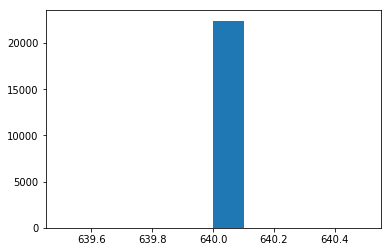

In [15]:
size_d = {k: PIL.Image.open(PATH+k).size for k in data.trn_ds.fnames}
row_sz, col_sz = list(zip(*size_d.values()))
row_sz = np.array(row_sz)
col_sz = np.array(col_sz)
plt.hist(row_sz)

(array([    0.,     0.,     0.,     0.,     0., 22424.,     0.,     0.,     0.,     0.]),
 array([479.5, 479.6, 479.7, 479.8, 479.9, 480. , 480.1, 480.2, 480.3, 480.4, 480.5]),
 <a list of 10 Patch objects>)

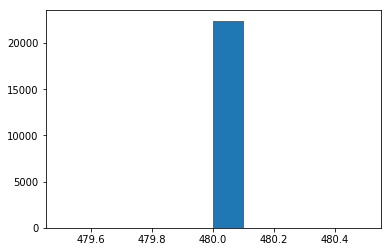

In [16]:
plt.hist(col_sz)

##  Learning

In [17]:
data = get_data(256)

In [18]:
net = ConvLearner.pretrained(net_arch, data)

In [19]:
#net.summary

In [20]:
lr = 0.1

In [21]:
net.fit(lr, 3, cycle_len=1, cycle_mult=2)

    1      0.448485   0.143093   0.954167                    
    2      0.279554   0.072478   0.977431                    
    3      0.715848   0.130712   0.959028                    
    4      0.351451   0.066998   0.979861                    
    5      0.22235    0.0407     0.988542                    
    6      0.209298   0.040749   0.988194                    



[array([0.04075]), 0.9881944444444445]

In [22]:
net.save(f'freezed')

In [23]:
lrs = np.array([lr/9,lr/3,lr])

In [24]:
net.unfreeze()
net.fit(lrs, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                    
    0      0.14796    0.067694   0.977778  
    2      0.036738   0.014497   0.995486                     
    3      0.088736   0.030509   0.990278                     
 28%|██▊       | 196/701 [03:33<09:10,  1.09s/it, loss=0.0641]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



    6      0.01189    0.001764   0.999306                      



[array([0.00176]), 0.9993055555555556]

In [25]:
net.save(f'256')

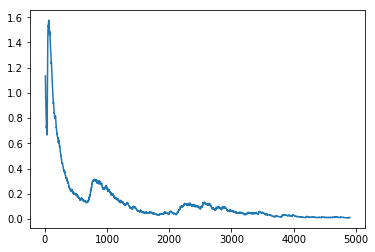

In [26]:
net.sched.plot_loss()

In [27]:
net.set_data(get_data(480))
net.freeze()
net.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                      
    0      0.008403   0.001512   0.999653  
    1      0.010038   0.001862   0.999653                      
    2      0.007341   0.00142    0.999653                      
    3      0.008032   0.001038   0.999653                      
    4      0.006609   0.001441   0.999653                      
    5      0.008655   0.001038   0.999653                      
    6      0.005951   0.001127   0.999653                      



[array([0.00113]), 0.9996527777777777]

In [ ]:
net.save(f'480_freezed')

In [28]:
net.unfreeze()
net.fit(lrs, 3, cycle_len=1, cycle_mult=2)
net.save(f'480_unfreezed')

epoch      trn_loss   val_loss   accuracy                     
    0      0.023244   0.002854   0.999306  
    1      0.028852   0.006384   0.997222                     
    2      0.009347   0.001244   0.999653                      
    3      0.036666   0.005621   0.998264                     
    4      0.019526   0.003414   0.998958                      
    5      0.006437   0.001056   0.999653                      
    6      0.00525    0.000653   0.999653                      



In [20]:
#net.load(f'480')

In [31]:
net.sh

AttributeError: 'NoneType' object has no attribute 'plot_loss'

## Validation checks

In [29]:
val_log_preds, y = net.TTA()
val_probs = np.exp(val_log_preds)
val_predicts = np.mean(val_probs, 0)

In [30]:
val_predicts[0]

array([0.99991, 0.     , 0.     , 0.00001, 0.     , 0.00003, 0.     , 0.     , 0.     , 0.00005],
      dtype=float32)

In [31]:
y[1]

0

## Making kaggle solution

In [21]:
test_log_preds, y = net.TTA(is_test=True)

In [22]:
test_probs = np.exp(test_log_preds)

Get mean among TTA

In [23]:
test_predicts = np.mean(test_probs, 0)

In [24]:
data.test_ds.fnames[0]

'test/img_37990.jpg'

In [25]:
test_predicts[0]

array([0.1521 , 0.00075, 0.00144, 0.00019, 0.00764, 0.76895, 0.02017, 0.03096, 0.01742, 0.00037],
      dtype=float32)

## Manual test checks

[0.99829 0.      0.      0.00004 0.      0.00164 0.      0.      0.      0.00002]


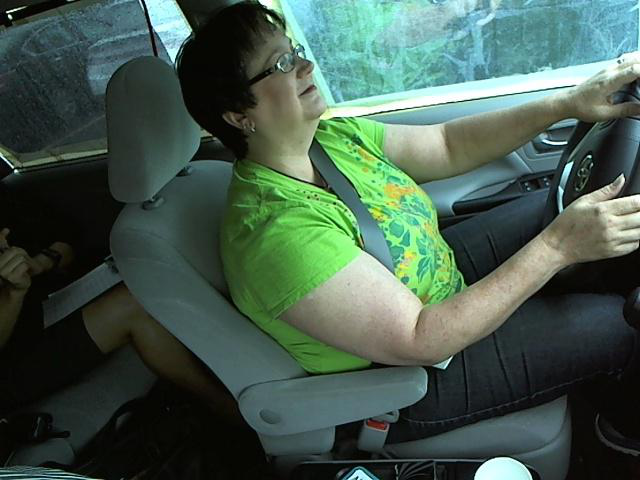

In [109]:
#check some values
check_i = 156
fn = PATH + data.test_ds.fnames[check_i];
print(test_predicts[check_i])
img = PIL.Image.open(fn); img

In [27]:
ds = pd.DataFrame(test_predicts)
ds.columns = data.classes
ds.insert(0, 'img', [o[5:] for o in data.test_ds.fnames])
ds.head()
SUBM = f'{PATH}subm/'
os.makedirs(SUBM, exist_ok=True)
ds.to_csv(f'{SUBM}subm18072018', index=False)
FileLink(f'{SUBM}subm')

/home/kuptservol/fastai/courses/dl1/data/state-farm-distracted-driver-detection/subm/subm

## Kernel

In [119]:
def identify_by_image(file_path, net_arch, img_sz):
        trn_tfms, val_tfrms = tfms_from_model(net_arch, img_sz)
        img = trn_tfms(open_image(file_path))
        preds = net.predict_array(img[None])
        return np.exp(preds)

def classes_by_threshold(classes, threshold, predicts):
    thres_classes = []
    i = 0
    for predict in predicts[0]:
        if predict > threshold:
            thres_classes.append(classes[i])
        i = i + 1
    return thres_classes

In [115]:
classes = [ 
    'normal driving',
    'texting - right',
    'talking on the phone - right',
    'texting - left',
    'talking on the phone - left',
    'operating the radio',
    'drinking',
    'reaching behind',
    'hair and makeup',
    'talking to passenger'
        ]

[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]
['drinking']
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


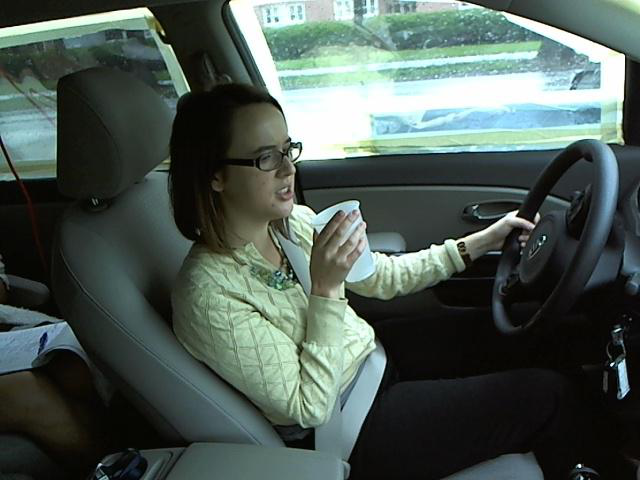

In [144]:
check_i = 12331
image_path = PATH + data.test_ds.fnames[check_i];
predicts = identify_by_image(image_path, net_arch, 400)
print(predicts)
print(classes_by_threshold(classes, 0.001, predicts))
print(test_predicts[check_i])
img = PIL.Image.open(image_path); img